In [1]:
# ---------------------------------------------------------------------
# 0. Imports and setup
# ---------------------------------------------------------------------
import os
import json
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import joblib
import warnings
warnings.filterwarnings("ignore")

# Ensure NLTK resources are available
nltk.download('vader_lexicon')

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.dpi'] = 120
sns.set(style='whitegrid')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create folders for outputs
os.makedirs('visualizations', exist_ok=True)
os.makedirs('deliverables', exist_ok=True)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# ---------------------------------------------------------------------
# 1. Load dataset
# ---------------------------------------------------------------------
DATA_FILE = 'test(in).csv'  # make sure this file is in the same folder as the notebook

# Read CSV
df = pd.read_csv(DATA_FILE)
print("Dataset loaded. Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(5)

Dataset loaded. Shape: (2191, 4)
Columns: ['Subject', 'body', 'date', 'from']


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [3]:
# ---------------------------------------------------------------------
# 2. Basic cleaning & preprocessing
# ---------------------------------------------------------------------
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Identify likely columns
date_col = None
from_col = None
subject_col = None
body_col = None

for c in df.columns:
    lc = c.lower()
    if lc in ('date', 'sent_date', 'sentdate'):
        date_col = c
    if lc in ('from', 'from_email', 'sender'):
        from_col = c
    if lc in ('subject', 'subject_line'):
        subject_col = c
    if lc in ('body', 'message', 'body_text', 'content'):
        body_col = c

# If not found, try fuzzy fallback:
if date_col is None:
    # try any column containing 'date'
    for c in df.columns:
        if 'date' in c.lower():
            date_col = c
            break
if from_col is None:
    for c in df.columns:
        if 'from' in c.lower() or 'email' in c.lower():
            from_col = c
            break
if subject_col is None:
    for c in df.columns:
        if 'subj' in c.lower():
            subject_col = c
            break
if body_col is None:
    for c in df.columns:
        if 'body' in c.lower() or 'message' in c.lower():
            body_col = c
            break

print(f"Using columns -> date: {date_col}, from: {from_col}, subject: {subject_col}, body: {body_col}")

# If any required column missing, create placeholders to avoid errors
if date_col is None:
    df['date'] = pd.NaT
    date_col = 'date'
if from_col is None:
    df['from'] = np.nan
    from_col = 'from'
if subject_col is None:
    df['Subject'] = ''
    subject_col = 'Subject'
if body_col is None:
    df['body'] = ''
    body_col = 'body'

# Convert date to datetime (try multiple formats)
df[date_col] = pd.to_datetime(df[date_col], errors='coerce', infer_datetime_format=True)

# Create employee id (username before @)
df['employee'] = df[from_col].astype(str).str.split('@').str[0].fillna('unknown')

# Create a combined text field
df['subject'] = df[subject_col].astype(str).fillna('')
df['body'] = df[body_col].astype(str).fillna('')
df['full_message'] = (df['subject'] + ' ' + df['body']).str.strip()

# Remove leading/trailing whitespace
df['employee'] = df['employee'].str.strip()

# Basic dataset info
print("\nAfter preprocessing:")
print("Total records:", len(df))
print("Date range:", df[date_col].min(), "to", df[date_col].max())
print("Unique employees:", df['employee'].nunique())

Using columns -> date: date, from: from, subject: Subject, body: body

After preprocessing:
Total records: 2191
Date range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00
Unique employees: 10


In [4]:
# ---------------------------------------------------------------------
# 3. Task 1: Sentiment Labeling (fast approach: VADER)
# ---------------------------------------------------------------------
sid = SentimentIntensityAnalyzer()

def vader_label(text, pos_thresh=0.05, neg_thresh=-0.05):
    if pd.isna(text) or text.strip() == '':
        return 'Neutral'
    scores = sid.polarity_scores(str(text))
    comp = scores['compound']
    if comp >= pos_thresh:
        return 'Positive'
    elif comp <= neg_thresh:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling
df['sentiment'] = df['full_message'].apply(vader_label)

# For transparency, also save raw vader scores
df_vader_scores = df['full_message'].apply(lambda t: sid.polarity_scores(str(t)))
vader_df = pd.DataFrame(list(df_vader_scores))
df = pd.concat([df.reset_index(drop=True), vader_df.reset_index(drop=True)], axis=1)

# Show distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())
print("\nSample labeled rows:")
display(df[['employee', date_col, 'subject', 'full_message', 'sentiment', 'compound']].head(6))

# Save labeled dataset
df.to_csv('deliverables/test_labeled.csv', index=False)
print("Saved labeled dataset -> deliverables/test_labeled.csv")


Sentiment distribution:
sentiment
Positive    1574
Neutral      454
Negative     163
Name: count, dtype: int64

Sample labeled rows:


,employee,date,subject,full_message,sentiment,compound
0,sally.beck,2010-05-10,EnronOptions Update!,EnronOptions Update! EnronOptions Announcement...,Positive,0.8309
1,eric.bass,2010-07-29,(No Subject),"(No Subject) Marc,\n\nUnfortunately, today is ...",Positive,0.4215
2,sally.beck,2011-07-25,Phone Screen Interview - Shannon L. Burnham,Phone Screen Interview - Shannon L. Burnham W...,Neutral,0.0000
3,johnny.palmer,2010-03-25,RE: My new work email,RE: My new work email we were thinking papasit...,Neutral,0.0000
4,lydia.delgado,2011-05-21,Bet,Bet Since you never gave me the $20 for the la...,Positive,0.2500
5,eric.bass,2011-10-23,RE: Favor,"RE: Favor sure, just call me the bank that del...",Positive,0.6124


Saved labeled dataset -> deliverables/test_labeled.csv


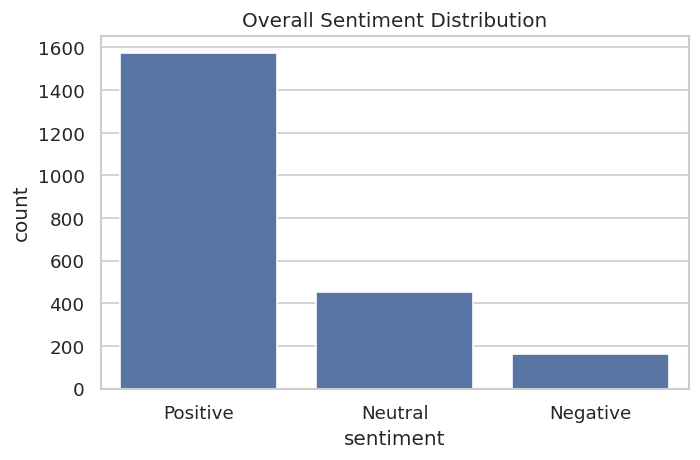

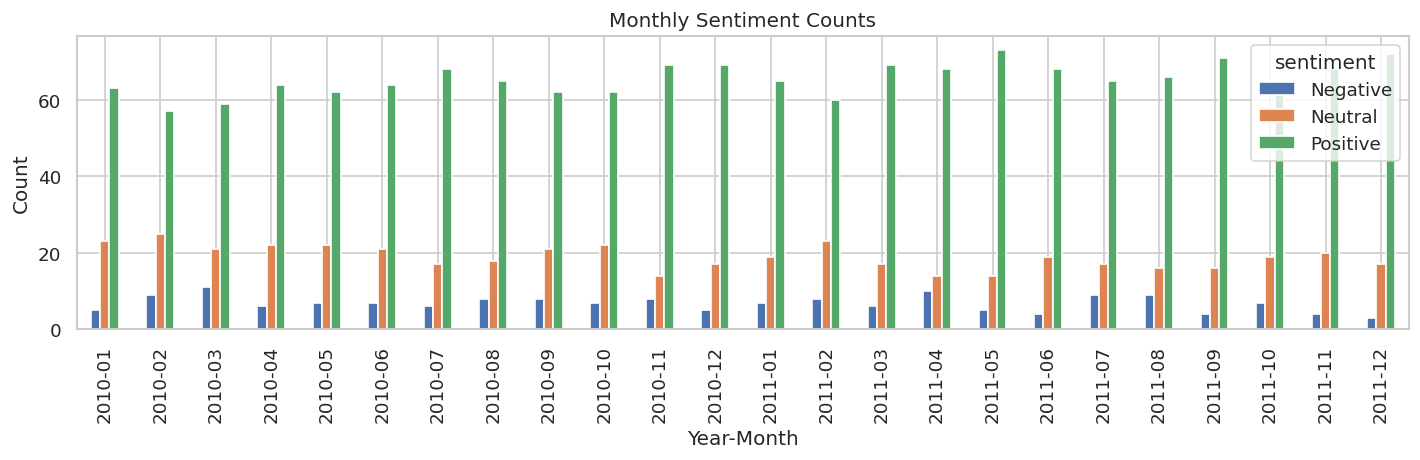

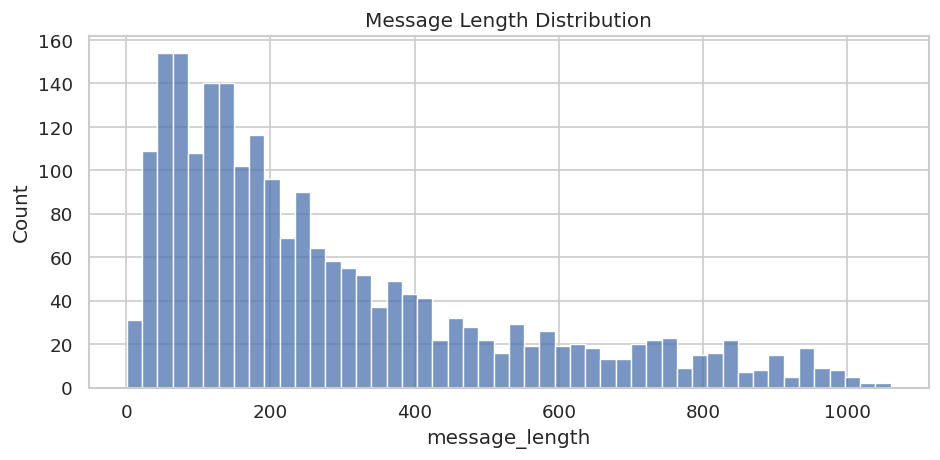

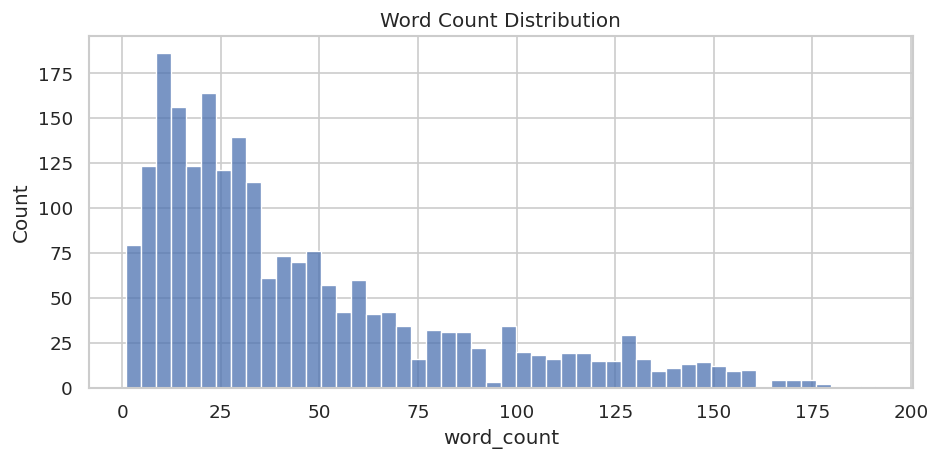

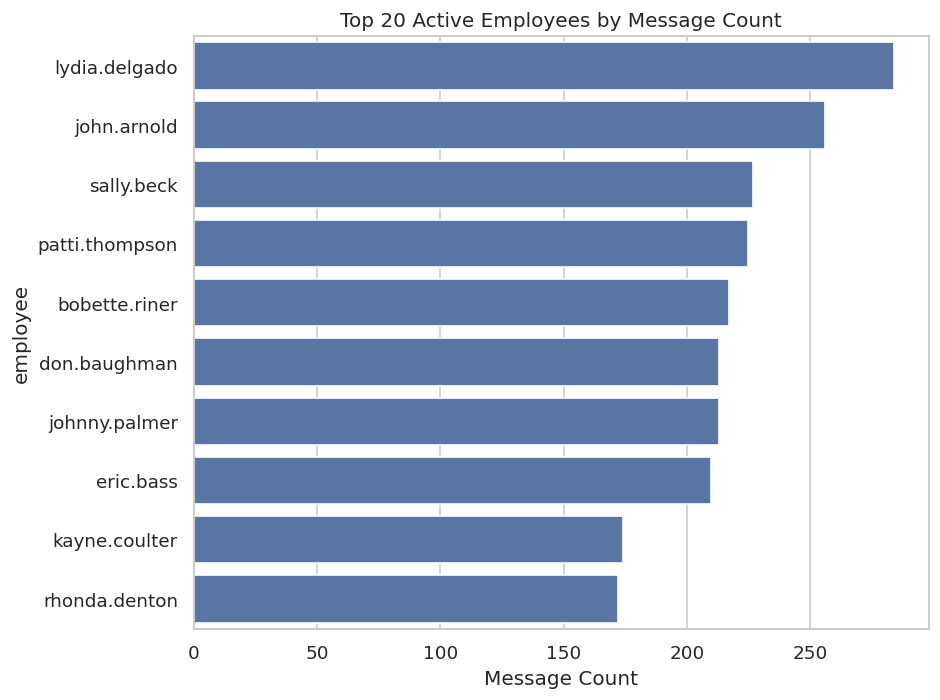

EDA summary saved -> deliverables/eda_summary.json


In [5]:
# ---------------------------------------------------------------------
# 4. Task 2: Exploratory Data Analysis (EDA)
# ---------------------------------------------------------------------
eda_summary = {
    'total_records': int(len(df)),
    'unique_employees': int(df['employee'].nunique()),
    'date_min': str(df[date_col].min()),
    'date_max': str(df[date_col].max()),
    'sentiment_counts': df['sentiment'].value_counts().to_dict()
}

# Plot: sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['Positive','Neutral','Negative'])
plt.title('Overall Sentiment Distribution')
plt.tight_layout()
plt.savefig('visualizations/sentiment_distribution.png')
plt.show()

# Time trend: make month-year period
df['year_month'] = df[date_col].dt.to_period('M')
monthly_sentiment = df.groupby(['year_month','sentiment']).size().unstack(fill_value=0)

# Plot monthly sentiment counts (if there are enough months)
if monthly_sentiment.shape[0] > 0:
    monthly_sentiment.plot(kind='bar', figsize=(12,4))
    plt.title('Monthly Sentiment Counts')
    plt.xlabel('Year-Month')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('visualizations/monthly_sentiment_trends.png')
    plt.show()

# Message length and word counts
df['message_length'] = df['full_message'].str.len().fillna(0)
df['word_count'] = df['full_message'].str.split().str.len().fillna(0)

plt.figure(figsize=(8,4))
sns.histplot(df['message_length'], bins=50, kde=False)
plt.title('Message Length Distribution')
plt.tight_layout()
plt.savefig('visualizations/message_length_distribution.png')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=50, kde=False)
plt.title('Word Count Distribution')
plt.tight_layout()
plt.savefig('visualizations/word_count_distribution.png')
plt.show()

# Top active employees
top_employees = df['employee'].value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(y=top_employees.index, x=top_employees.values)
plt.title('Top 20 Active Employees by Message Count')
plt.xlabel('Message Count')
plt.tight_layout()
plt.savefig('visualizations/top_employees.png')
plt.show()

# Save EDA summary
with open('deliverables/eda_summary.json', 'w') as f:
    json.dump(eda_summary, f, indent=2)
print("EDA summary saved -> deliverables/eda_summary.json")

In [6]:
# ---------------------------------------------------------------------
# 5. Task 3: Employee Score Calculation (monthly)
# ---------------------------------------------------------------------v
df['score'] = df['sentiment'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0}).fillna(0).astype(int)

# Group by employee and month -> monthly sentiment score
monthly_scores = df.groupby(['employee','year_month'])['score'].sum().reset_index()
monthly_scores.rename(columns={'score':'monthly_score'}, inplace=True)

# Ensure year_month is Period to preserve ordering; convert to string for CSV
monthly_scores['year_month_str'] = monthly_scores['year_month'].astype(str)

# Save monthly scores
monthly_scores.to_csv('deliverables/monthly_employee_scores.csv', index=False)
print("Monthly scores saved -> deliverables/monthly_employee_scores.csv")
monthly_scores.head(8)


Monthly scores saved -> deliverables/monthly_employee_scores.csv


,employee,year_month,monthly_score,year_month_str
0,bobette.riner,2010-01,1,2010-01
1,bobette.riner,2010-02,8,2010-02
2,bobette.riner,2010-03,4,2010-03
3,bobette.riner,2010-04,3,2010-04
4,bobette.riner,2010-05,3,2010-05
5,bobette.riner,2010-06,2,2010-06
6,bobette.riner,2010-07,8,2010-07
7,bobette.riner,2010-08,4,2010-08


In [7]:
# ---------------------------------------------------------------------
# 6. Task 4: Employee Ranking (Top 3 positive and Top 3 negative by month)
# ---------------------------------------------------------------------
rankings = {}
for ym in sorted(monthly_scores['year_month'].unique()):
    month_df = monthly_scores[monthly_scores['year_month'] == ym].copy()
    # sort descending by monthly_score then by employee name
    top_pos = month_df.sort_values(['monthly_score','employee'], ascending=[False, True]).head(3)
    # top negative: lowest scores. sort ascending then by name
    top_neg = month_df.sort_values(['monthly_score','employee'], ascending=[True, True]).head(3)
    rankings[str(ym)] = {
        'top_positive': top_pos[['employee','monthly_score']].to_dict('records'),
        'top_negative': top_neg[['employee','monthly_score']].to_dict('records')
    }

# Save rankings
with open('deliverables/monthly_rankings.json','w') as f:
    json.dump(rankings, f, indent=2)

print("Monthly rankings saved -> deliverables/monthly_rankings.json")
# Print sample
for ym, info in list(rankings.items())[:3]:
    print("\nMonth:", ym)
    print("Top Positive:", info['top_positive'])
    print("Top Negative:", info['top_negative'])

Monthly rankings saved -> deliverables/monthly_rankings.json

Month: 2010-01
Top Positive: [{'employee': 'kayne.coulter', 'monthly_score': 14}, {'employee': 'eric.bass', 'monthly_score': 9}, {'employee': 'lydia.delgado', 'monthly_score': 9}]
Top Negative: [{'employee': 'bobette.riner', 'monthly_score': 1}, {'employee': 'rhonda.denton', 'monthly_score': 1}, {'employee': 'sally.beck', 'monthly_score': 2}]

Month: 2010-02
Top Positive: [{'employee': 'john.arnold', 'monthly_score': 12}, {'employee': 'johnny.palmer', 'monthly_score': 10}, {'employee': 'bobette.riner', 'monthly_score': 8}]
Top Negative: [{'employee': 'kayne.coulter', 'monthly_score': 1}, {'employee': 'lydia.delgado', 'monthly_score': 1}, {'employee': 'patti.thompson', 'monthly_score': 1}]

Month: 2010-03
Top Positive: [{'employee': 'sally.beck', 'monthly_score': 11}, {'employee': 'john.arnold', 'monthly_score': 7}, {'employee': 'eric.bass', 'monthly_score': 6}]
Top Negative: [{'employee': 'rhonda.denton', 'monthly_score': 1}


Flight risk employees (count): 4
['eric.bass', 'johnny.palmer', 'patti.thompson', 'sally.beck']
Flight risk details saved -> deliverables/flight_risk_employees.csv & .json


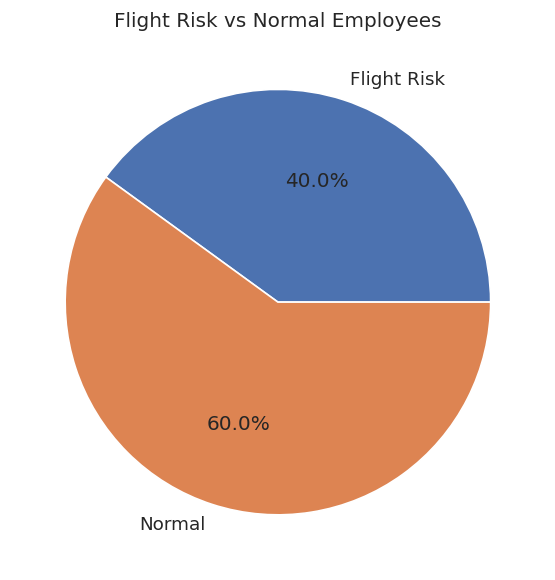

In [8]:
# ---------------------------------------------------------------------
# 7. Task 5: Flight Risk Identification (rolling 30-day window)
# ---------------------------------------------------------------------
neg_df = df[df['sentiment'] == 'Negative'].dropna(subset=[date_col]).sort_values(['employee', date_col]).copy()

flight_risk_employees = set()
flight_risk_details = []

for emp in neg_df['employee'].unique():
    emp_dates = neg_df[neg_df['employee'] == emp][date_col].sort_values().tolist()
    # two-pointer/sliding window
    i = 0
    j = 0
    n = len(emp_dates)
    while i < n:
        # Move j to include dates within 30 days from emp_dates[i]
        while j < n and (emp_dates[j] - emp_dates[i]).days < 30:
            j += 1
        count_in_window = j - i
        if count_in_window >= 4:
            # found a flight risk window
            flight_risk_employees.add(emp)
            flight_risk_details.append({
                'employee': emp,
                'window_start': str(emp_dates[i].date()),
                'window_end': str(emp_dates[j-1].date()),
                'negative_count': int(count_in_window)
            })
            break
        i += 1

flight_risk_list = sorted(list(flight_risk_employees))
print("\nFlight risk employees (count):", len(flight_risk_list))
print(flight_risk_list)

# Save flight risk report
pd.DataFrame(flight_risk_details).to_csv('deliverables/flight_risk_employees.csv', index=False)
with open('deliverables/flight_risk_employees.json','w') as f:
    json.dump(flight_risk_details, f, indent=2)
print("Flight risk details saved -> deliverables/flight_risk_employees.csv & .json")

# Simple visualization: Pie of flight risk vs normal (if any flight risks)
if len(flight_risk_list) > 0:
    status_counts = pd.Series({'Flight Risk': len(flight_risk_list), 'Normal': df['employee'].nunique() - len(flight_risk_list)})
    plt.figure(figsize=(5,5))
    status_counts.plot(kind='pie', autopct='%1.1f%%', title='Flight Risk vs Normal Employees')
    plt.ylabel('')
    plt.tight_layout()
    plt.savefig('visualizations/flight_risk_pie.png')
    plt.show()


Modeling dataset shape: (240, 15)
Target distribution:
 count    240.000000
mean       5.879167
std        4.026843
min       -1.000000
25%        2.750000
50%        5.000000
75%        8.000000
max       20.000000
Name: monthly_score, dtype: float64

Linear Regression Performance:
Training: {'MSE': 0.9782485407393556, 'RMSE': np.float64(0.9890644775439849), 'MAE': 0.7248739145184269, 'R2': 0.9431073367497147}
Testing: {'MSE': 1.0532482667442993, 'RMSE': np.float64(1.0262788445370485), 'MAE': 0.7431110621742922, 'R2': 0.9103486032740186}
Saved model & scaler to deliverables/
Feature coefficients saved -> deliverables/feature_coefficients.csv


,feature,coefficient
0,message_frequency,4.070566
13,negative_ratio,-1.133215
14,neutral_ratio,-0.958047
6,max_word_count,-0.519472
4,std_message_length,0.481877
11,length_frequency_ratio,-0.422450
7,min_word_count,0.358464
1,avg_message_length,0.154928
2,max_message_length,-0.112639
3,min_message_length,-0.057411


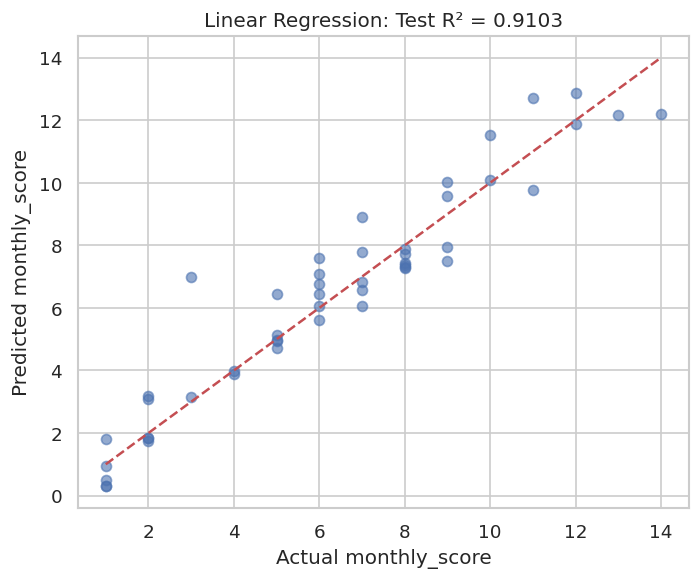

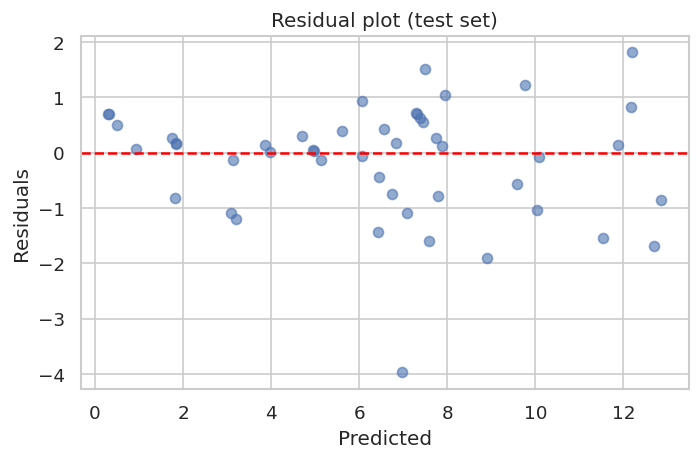

Model summary saved -> deliverables/model_summary.json


In [10]:
# ---------------------------------------------------------------------
# 8. Task 6: Predictive Modeling (Linear Regression)
#    - Build features aggregated monthly per employee (no leakage)
#    - Use only features available before/within month (we won't use future sentiment counts)
# ---------------------------------------------------------------------
agg = df.groupby(['employee','year_month']).agg(
    message_frequency = ('full_message','count'),
    avg_message_length = ('message_length','mean'),
    max_message_length = ('message_length','max'),
    min_message_length = ('message_length','min'),
    std_message_length = ('message_length','std'),
    avg_word_count = ('word_count','mean'),
    max_word_count = ('word_count','max'),
    min_word_count = ('word_count','min'),
    std_word_count = ('word_count','std'),
).reset_index()

# Instead compute positive/negative/neutral counts separately
counts = df.groupby(['employee','year_month','sentiment']).size().unstack(fill_value=0).reset_index()
# Merge
model_df = agg.merge(counts, on=['employee','year_month'], how='left').fillna(0)

# Add target monthly_score (already computed)
monthly_score_df = monthly_scores[['employee','year_month','monthly_score']]
model_df = model_df.merge(monthly_score_df, on=['employee','year_month'], how='left')

# Add lag feature (previous month message_frequency)
model_df = model_df.sort_values(['employee','year_month'])
model_df['prev_month_frequency'] = model_df.groupby('employee')['message_frequency'].shift(1).fillna(0)
model_df['prev_month_avg_length'] = model_df.groupby('employee')['avg_message_length'].shift(1).fillna(0)

# Add ratio features
model_df['length_frequency_ratio'] = model_df['avg_message_length'] / (model_df['message_frequency'] + 1)
model_df['positive_ratio'] = model_df['Positive'] / (model_df['message_frequency'] + 1)
model_df['negative_ratio'] = model_df['Negative'] / (model_df['message_frequency'] + 1)
model_df['neutral_ratio'] = model_df['Neutral'] / (model_df['message_frequency'] + 1)

# Fill NaNs in std columns
model_df['std_message_length'] = model_df['std_message_length'].fillna(0)
model_df['std_word_count'] = model_df['std_word_count'].fillna(0)

# Drop rows with missing target
model_df_clean = model_df.dropna(subset=['monthly_score']).copy()

# Feature list (choose reasonable features; avoid target leakage)
feature_cols = [
    'message_frequency', 'avg_message_length', 'max_message_length', 'min_message_length',
    'std_message_length', 'avg_word_count', 'max_word_count', 'min_word_count', 'std_word_count',
    'prev_month_frequency', 'prev_month_avg_length', 'length_frequency_ratio',
    'positive_ratio', 'negative_ratio', 'neutral_ratio'
]

# Ensure all feature columns exist
for c in feature_cols:
    if c not in model_df_clean.columns:
        model_df_clean[c] = 0

X = model_df_clean[feature_cols].fillna(0)
y = model_df_clean['monthly_score'].astype(float)

print("\nModeling dataset shape:", X.shape)
print("Target distribution:\n", y.describe())

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

# Scale features (important for linear regression coefficients stability)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Evaluate
def metrics_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = metrics_report(y_train, y_train_pred)
test_metrics = metrics_report(y_test, y_test_pred)

print("\nLinear Regression Performance:")
print("Training:", train_metrics)
print("Testing:", test_metrics)

# Save model and scaler
joblib.dump(lr, 'deliverables/linear_regression_model.joblib')
joblib.dump(scaler, 'deliverables/feature_scaler.joblib')
print("Saved model & scaler to deliverables/")

# Coefficients (map back to feature names)
coef_df = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)
coef_df.to_csv('deliverables/feature_coefficients.csv', index=False)
print("Feature coefficients saved -> deliverables/feature_coefficients.csv")
display(coef_df)

# Visualization: Actual vs Predicted for test set
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual monthly_score')
plt.ylabel('Predicted monthly_score')
plt.title(f'Linear Regression: Test R² = {test_metrics["R2"]:.4f}')
plt.tight_layout()
plt.savefig('visualizations/model_actual_vs_predicted.png')
plt.show()

# Residual plot
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual plot (test set)')
plt.tight_layout()
plt.savefig('visualizations/model_residuals.png')
plt.show()

# Save model metrics summary
model_summary = {
    'train_metrics': {k: float(v) for k,v in train_metrics.items()},
    'test_metrics': {k: float(v) for k,v in test_metrics.items()},
    'feature_coefficients': coef_df.to_dict('records')
}
with open('deliverables/model_summary.json','w') as f:
    json.dump(model_summary, f, indent=2)

print("Model summary saved -> deliverables/model_summary.json")